# Rasterizing vectors & vectorizing rasters

**Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments**

### Background

It's very common in a remote sensing and/or geopsatial workflow to require converting between vector data (e.g. shapefiles) and raster data (e.g. pixel-based data like that in an xarray.DataArray).  For example, often we'll have a shapefile that we want to use as a mask to limit the analysis extent of a raster.  Or we'll have raster data that we want to convert into vector data to allow for easy geometry operations.

### Description
This notebook demonstrates the use of the python package [Rasterio](https://rasterio.readthedocs.io/en/stable/index.html) to convert between raster and vector data.  

The first section loads in [Water Observations from Space (WOfS)](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) data from the `datacube`, and converts the pixel-based `xarray.DataArray` object into a `geopandas.GeoDataFrame` object containing persistent water-bodies as `polygons`. We then export the geoDataframe as a `shapefile`.  

The second section reconverts the vector data we created in the first section back into an `xarray.DataArray` and exports the results as a `geotiff`


### Technical details
* **Products used:** `WOfS`
* **Analyses used:** `rasterio.features.rasterize`, `rasterio.features.shapes`, `geopandas.GeoDataFrame`
* **Special requirements:** In order for geopandas plotting methods to work on the Sandbox, `descartes` needs to be manually installed.  This can be done by running the following command in a cell:

    - `!pip install --user descartes`

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
%matplotlib inline

import datacube
import rasterio.features
import shapely
import geopandas as gpd
import numpy as np
import xarray as xr
from datacube.helpers import write_geotiff
import pprint

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Rasterize and Vectorize")

## Load WoFS data from the datacube

We will load in an annual summary from the [Water Observations from Space (WOfS)](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) product to provide us with some data to work with.  The query below will load the 2016 annual summary of WOfS for the region around the Menindee Lakes.

In [3]:
# Create a query object
query = {
    'x': (142.1, 142.80),
    'y': (-32.1, -32.6),
    'time': ('2016')
}

# load WoFS through the datacube
ds = dc.load(product='wofs_annual_summary', **query)

print(ds)


<xarray.Dataset>
Dimensions:      (time: 1, x: 2789, y: 2443)
Coordinates:
  * time         (time) datetime64[ns] 2016-01-01
  * y            (y) float64 -3.536e+06 -3.536e+06 ... -3.597e+06 -3.597e+06
  * x            (x) float64 9.396e+05 9.396e+05 ... 1.009e+06 1.009e+06
Data variables:
    count_wet    (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    count_clear  (time, y, x) int16 40 40 39 39 40 41 42 ... 23 23 23 23 23 22
    frequency    (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    crs:      EPSG:3577


### Plot the WOfS summary

Let's plot the WOfS data to get an idea of the objects we will be transforming.  In the code below, we first select the pixels where the satellite has observed water at least 25 % of the year, this is so we can isolate the more persistent water bodies and reduce some of the noise before we vectorize the raster.

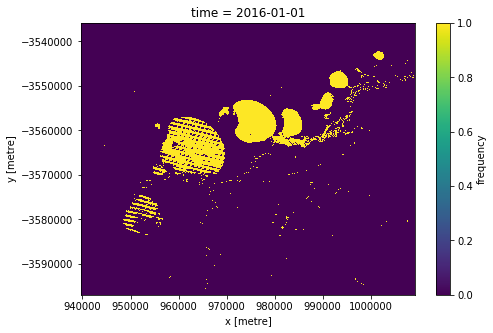

In [4]:
#select pixels that are classified as water > 25 % of the time
water_bodies = ds.frequency > 0.25

#plot
water_bodies.plot(size=5)

## Vectorizing an xarray.DataArray


Using [rasterio.features.shape](https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html), we will turn our `xarray.DataArray` of the persistent water bodies into a shapefile.
- The `source` parameter requires a simple numpy array, with the datatype explicitly set. 
- We can use the `mask` parameter to set which values in the array we want to convert to vectors, in this instance, we want to convert only the values of 1, which correspond to the persistent water bodies in the dataArray. 
- The `transform` parameter provides the geospatial coordinates to transform the array into a geo-located shapefile.  We can get this from our original xarray dataset

In [5]:
# First grab the spatial information from our datacube xarray object
transform = ds.geobox.transform

# Run the vectorizing function
vectors = rasterio.features.shapes(source=water_bodies.data.astype('int16'),
                                   mask=(water_bodies.data == 1),
                                   transform=transform)


The returned object is a `generator` that contains the `(polygon, value)` pair for each unique feature in the array.  Before we can create a shapefile, we first need to unpack the generator objects into lists which are easier to manipulate.

The last part of the code will print the first (polygon, value) pair to show what these objects look like.

In [6]:
# first convert the genertor into a list, as a generator can only be consumed once
vectors = list(vectors)

# extract the polygons and values from the list using list comprehension
polygons = [shape for shape, value in vectors]
values = [value for shape, value in vectors]

print("Image value: " + str(values[0]))
print("Geometry:")
pprint.pprint(polygons[0])


Image value: 1.0
Geometry:
{'coordinates': [[(943150.0, -3535850.0),
                  (943150.0, -3535875.0),
                  (943125.0, -3535875.0),
                  (943125.0, -3535925.0),
                  (943175.0, -3535925.0),
                  (943175.0, -3535900.0),
                  (943200.0, -3535900.0),
                  (943200.0, -3535875.0),
                  (943175.0, -3535875.0),
                  (943175.0, -3535850.0),
                  (943150.0, -3535850.0)]],
 'type': 'Polygon'}


Now that we have a list of geometries and values, we can add these to a [geopandas.GeoDataFrame](http://geopandas.org/). Geopandas is a very useful library for handling vector data as it extends the datatypes used by pandas to allow spatial operations.

In [7]:
# create a geopandas dataframe populated with the polygons
gdf = gpd.GeoDataFrame(polygons)

# loop through the rows and convert each geometry into Shapely polygon
for ix, poly in gdf.iterrows():
    poly['coordinates'] = shapely.geometry.shape(poly)

# rename the coordinates column to 'geometry', this is required to
# allow geopandas to plot th polygons
gdf = gdf.rename(columns={'coordinates': 'geometry'})

# add our values to an attribute column
gdf['attrs'] = values


### Plot our vectorised raster 

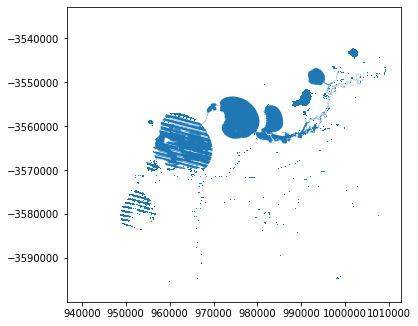

In [8]:
gdf.plot(figsize=(6,6))

### Export as shapefile

Geopandas allows us to very easily export the geodataframe as a shapefile for use in other applications.

In [9]:
gdf.to_file('water_bodies.shp')

## Rasterizing a shapefile

Using [rasterio.features.rasterize](https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html) we can turn the `geopandas.GeoDataFrame` back into a `xarray.Dataset`. As we already have the geodataframe loaded we don't need to read in the shapefile, but if we wanted to read in a shapefile first we can use [gpd.read_file()](http://geopandas.org/reference/geopandas.read_file.html).   

The first step is to extract an iterable of `(geometry, value)` pairs from the `gdf` object:

In [10]:
# instantiate an empty list
shapes = []

# loop through the geoseries of polygons and
# values and  add to the 'shapes' list
geoms = gdf['geometry']
attributes = gdf['attrs']

for poly, val in zip(geoms, attributes):
    shapes.append((poly, val))


We can now use the (geometry, value) iterable `shapes` to rasterize the polygons using `rasterio.features.rasterize`.  We also need to extract a `transform` object and the `x,y` length of the output array; this information we can grab from the intial WOfS dataset.

In [11]:
# First grab the spatial information from our datacube xarray object
transform = ds.geobox.transform
y,x = ds.frequency.squeeze().values.shape

#now convert the polgons into a numpy array
water_bodies_again = rasterio.features.rasterize(shapes = shapes,
                          out_shape = (y,x),
                          all_touched = False, 
                          fill = np.nan,
                          transform=transform)


Finally, we can convert our array back into an xarray.Dataset object for plotting and exporting as a geotiff

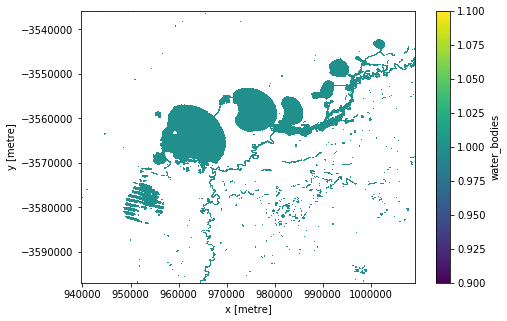

In [12]:
# convert result to a xarray dataarray using coords etc from original dc.load dataset
water_bodies_again = xr.DataArray(water_bodies_again,
                                  coords=[ds.y, ds.x],
                                  dims=['y', 'x'],
                                  name='water_bodies',
                                  attrs=ds.attrs)

# convert to xarray dataset to assist with writing to geotiff
water_bodies_again = water_bodies_again.to_dataset()
water_bodies_again.attrs = ds.attrs

#plot the result
water_bodies_again.water_bodies.plot(size=5)


### Export as geotiff

In [13]:
write_geotiff('water_bodies_again.tif', water_bodies_again)

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2019

**Compatible `datacube` version:** 

In [14]:
print(datacube.__version__)

1.7+43.gc873f3ea.dirty


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)